In [1]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import matplotlib
import matplotlib.pyplot as plt
from scipy.linalg import orthogonal_procrustes, norm
#matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

from ssm.models import HMM
from ssm.util import find_permutation

#### ####################################
##### load .mat Bond data ##############
import scipy.io as spio

mat_spk = spio.loadmat('spk_mpp_bond.mat', squeeze_me=True);
spk_train_tet = mat_spk['spk_train'];
spk_marks_tet = mat_spk['spk_mark'];

mat_behav = spio.loadmat('behav_mpp_bond.mat', squeeze_me=True);
pos_x = mat_behav['pyssm_x1ms'];
pos_y = mat_behav['pyssm_y1ms'];
poslin = mat_behav['pyssm_poslinLR1ms'];
swr_seg = mat_behav['pyssm_SWRs1ms'];
swr_id = mat_behav['pyssm_SWRs_vel'];
velocity = mat_behav['pyssm_vel1ms'];
run_seg = mat_behav['pyssm_RUN'];
tlin = mat_behav['pyssm_ti'];

#### format spike-mark matrix, #timebin by #tet (by #maxspk=1) by 5
n_tbin = tlin.shape[0]
n_tet = spk_train_tet.shape[0]
n_mark = spk_marks_tet[0].shape[1]
spmark = np.zeros((n_tbin, n_tet, n_mark+1))

for i_n_tet in range(n_tet):
    spmark[:, i_n_tet, 0] = spk_train_tet[i_n_tet]
    spmark[:, i_n_tet, 1:] = spk_marks_tet[i_n_tet]


In [3]:
### ############################################## ###
###        Fit an HMM to ~3 minutes of data        ###
### ############################################## ###

maxispk = 50
K = 20      # number of discrete states, e.g. location
D0 = n_tet  # number of tetrodes
D1 = maxispk # max number of events (Poisson)
D2 = n_mark+1 # spike count dimension (per event 0 or 1) + four mark dimensions
D = (D0, D1, D2) # tuple

### an example section of spiking data, and bin it
tbin_section = np.linspace(100001, 300000, 200000).astype(int)
timebin = 100 ## 100 msec time bin

from ssm.preprocessing import mpp_bin

spmark_bin = mpp_bin(spmark, tbin_section, n_tet, n_mark, maxispk, timebin)

### bin behavioral data, too
dur_section = tbin_section.shape[0]
T_bin = int(dur_section / timebin)
poslin_bin = np.mean(poslin[tbin_section].reshape(T_bin, timebin), axis=1)
pos_x_bin = np.mean(pos_x[tbin_section].reshape(T_bin, timebin), axis=1)
pos_y_bin = np.mean(pos_y[tbin_section].reshape(T_bin, timebin), axis=1)

#### true Zs and true ell
posbin_edges = np.linspace(np.floor(np.min(poslin_bin)),np.ceil(np.max(poslin_bin)),K+1)
z_true = np.digitize(poslin_bin, posbin_edges) - 1

posbin_x = np.zeros(K)
posbin_y = np.zeros(K)
for i in range(K):
    posbin_x[i] = pos_x_bin[z_true==i].mean(axis=0)
    posbin_y[i] = pos_y_bin[z_true==i].mean(axis=0)
  
true_maze = np.concatenate((posbin_x[:, None], posbin_y[:, None]),axis=1)

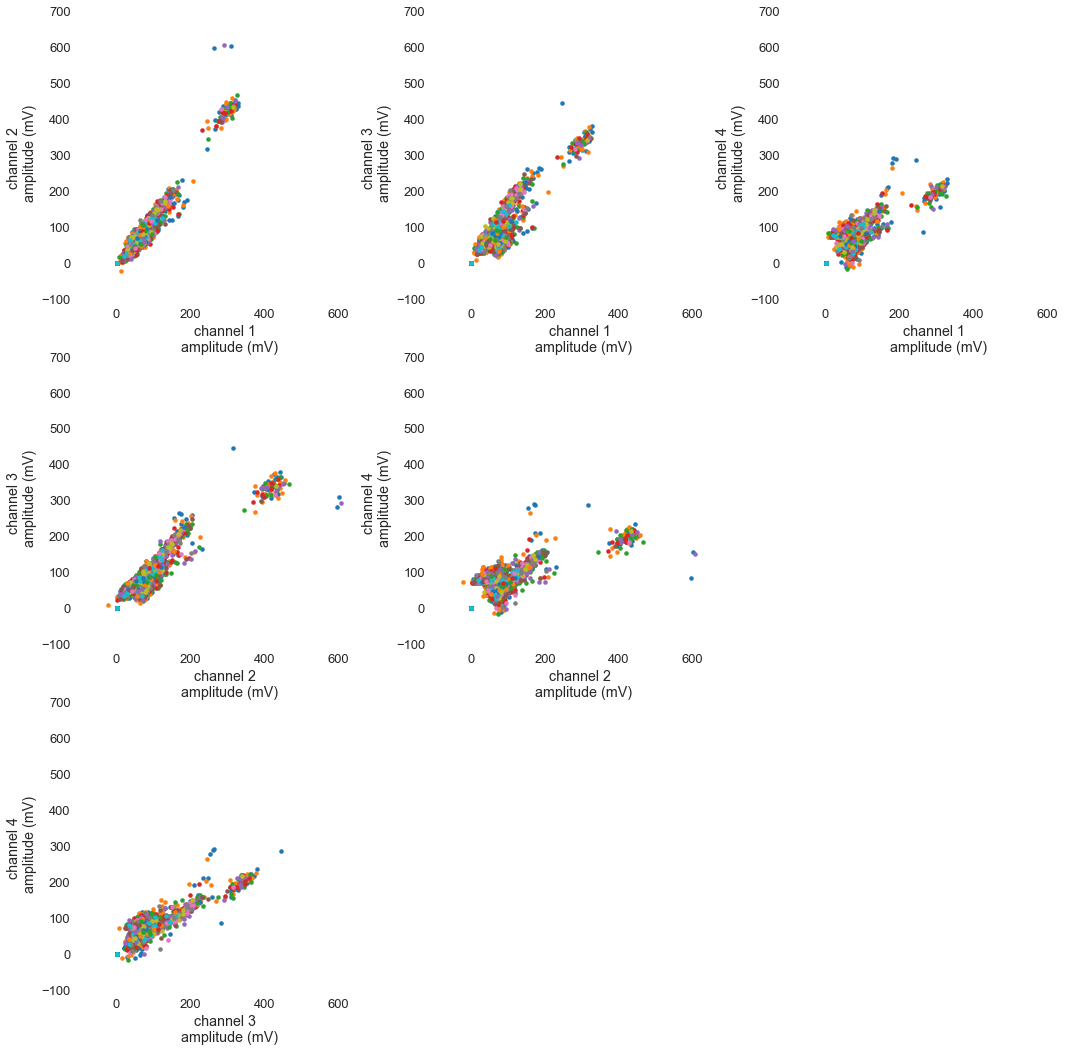

In [16]:
#### ###########################
#### plot the data
#### ##########################

#### plot mark on a tetrode
plt.figure(figsize=(18, 18))
plt.subplot(331)
plt.plot(spmark_bin[:, 0, :, 1], spmark_bin[:, 0, :, 2],'.')
plt.xlim(-100, 700); plt.ylim(-100, 700);
plt.xlabel('channel 1 \n amplitude (mV)');
plt.ylabel('channel 2 \n amplitude (mV)');
for spine in plt.gca().spines.values():
    spine.set_visible(False)
    
plt.subplot(332)
plt.plot(spmark_bin[:, 0, :, 1], spmark_bin[:, 0, :, 3],'.')
plt.xlim(-100, 700); plt.ylim(-100, 700);
plt.xlabel('channel 1 \n amplitude (mV)');
plt.ylabel('channel 3 \n amplitude (mV)');
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.subplot(333)
plt.plot(spmark_bin[:, 0, :, 1], spmark_bin[:, 0, :, 4],'.')
plt.xlim(-100, 700); plt.ylim(-100, 700);
plt.xlabel('channel 1 \n amplitude (mV)');
plt.ylabel('channel 4 \n amplitude (mV)');
for spine in plt.gca().spines.values():
    spine.set_visible(False)
    
plt.subplot(334)
plt.plot(spmark_bin[:, 0, :, 2], spmark_bin[:, 0, :, 3],'.')
plt.xlim(-100, 700); plt.ylim(-100, 700);
plt.xlabel('channel 2 \n amplitude (mV)');
plt.ylabel('channel 3 \n amplitude (mV)');
for spine in plt.gca().spines.values():
    spine.set_visible(False)
    
plt.subplot(335)
plt.plot(spmark_bin[:, 0, :, 2], spmark_bin[:, 0, :, 4],'.')
plt.xlim(-100, 700); plt.ylim(-100, 700);
plt.xlabel('channel 2 \n amplitude (mV)');
plt.ylabel('channel 4 \n amplitude (mV)');
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.subplot(337)
plt.plot(spmark_bin[:, 0, :, 3], spmark_bin[:, 0, :, 4],'.')
plt.xlim(-100, 700); plt.ylim(-100, 700);
plt.xlabel('channel 3 \n amplitude (mV)');
plt.ylabel('channel 4 \n amplitude (mV)');
for spine in plt.gca().spines.values():
    spine.set_visible(False)

In [17]:
#### #################################################### ###
###  fit dist-HMM to 100msec-time-binned locomotion data  ###
### ##################################################### ###

N_iters = 30
hmm = HMM(K, D, transitions="distance", observations="clusterless")
hmm_lls = hmm.fit(spmark_bin, method="em", num_em_iters=N_iters)
    
# Find a permutation of the states that best matches the true and inferred states
hmm.permute(find_permutation(z_true.astype(int), hmm.most_likely_states(spmark_bin)))
hmm_z = hmm.most_likely_states(spmark_bin)

### parameter estimates #################
L_hmm = hmm.transitions.L  # length scale/smoothing
ell_hmm = hmm.transitions.ell # latent 2D space
log_p_hmm = hmm.params[1][1]
prr_hmm = np.exp(log_p_hmm) # diagonal prob
Ps_dist_hmm = np.sum((ell_hmm[:, :, None] - ell_hmm[:, :, None].T) ** 2, axis = 1)
log_P_hmm = -Ps_dist_hmm / L_hmm
log_P_hmm += np.diag(log_p_hmm)
Ps_hmm = np.exp(log_P_hmm)
Ps_hmm /= Ps_hmm.sum(axis=1, keepdims=True)

LP: -2337855.2: 100%|██████████████████████████████████████████████████████████████████| 30/30 [08:14<00:00, 16.47s/it]


In [18]:
### ################################### ###
###        Empirical Zs, ell, Ps        ###
### ################################### ###

# Ps
def transition_matrix(transitions):
    n = 1+ np.max(transitions) #number of states

    A = [[0]*n for _ in range(n)]

    for (i,j) in zip(transitions,transitions[1:]):
        A[i][j] += 1

    #now convert to probabilities:
    for row in A:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return A

A = transition_matrix(z_true)


### align inferred 2D space with true maze
from scipy.linalg import orthogonal_procrustes, norm

def orthogonal_transformation(A, B):
    # A: input matrix
    # B: target matrix
    A_mu = A - A.mean(axis=0)
    B_mu = B - B.mean(axis=0)
    R, _ = orthogonal_procrustes(A_mu, B_mu)
    # We only want the orthogonal transformation.
    # If we scale it we will change the effective transition matrix.
    A2 = np.dot(A_mu, R) + B.mean(axis=0)
    
    return A2

ell_transform = orthogonal_transformation(ell_hmm, true_maze)


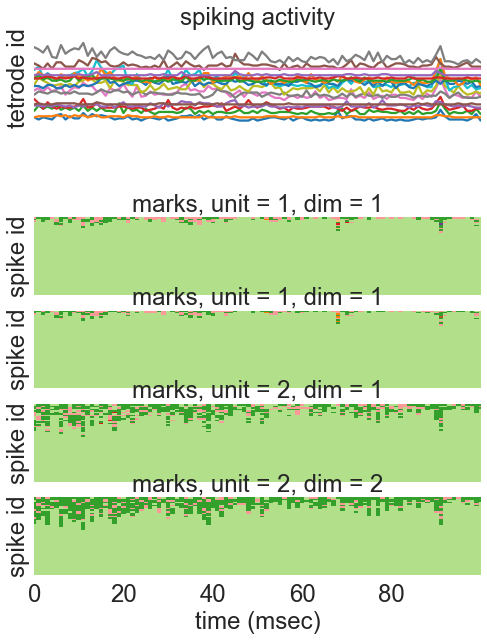

In [39]:
### #################################### #####
###              Plot the fit            #####
### #################################### #####

spikes = np.sum(spmark_bin[:, :, :, 0], axis=2) # T by D0
marks = spmark_bin[:, :, :, 1:] # T by D0 by D2 by D3

##### marked point process
plt.figure(figsize=(8, 10))
plt.subplot(511)
plt.plot(spikes + 3 * np.arange(D0),  '-')
plt.xlim(0, 100)
plt.title("spiking activity", fontsize=24)
plt.ylabel('tetrode id', fontsize=24)
plt.xticks(np.arange(0, 60, step=20), fontsize=24)
plt.yticks([])
plt.xticks([])
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.subplot(613)
plt.imshow(np.transpose(marks[:, 0, :, 0]), cmap="Paired", vmin=-100, vmax=400, aspect="auto")
plt.xlim(0, 100)
plt.title("marks, unit = 1, dim = 1", fontsize=24)
plt.yticks([]); plt.xticks([])
plt.ylabel("spike id", fontsize=24)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.subplot(614)
plt.imshow(np.transpose(marks[:, 0, :, 1]), cmap="Paired", vmin=-100, vmax=400, aspect="auto")
plt.xlim(0, 100)
plt.title("marks, unit = 1, dim = 1", fontsize=24)
plt.yticks([]); plt.xticks([])
plt.ylabel("spike id", fontsize=24)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.subplot(615)
plt.imshow(np.transpose(marks[:, 17, :, 0]), cmap="Paired", vmin=-100, vmax=400, aspect="auto")
plt.xlim(0, 100)
plt.title("marks, unit = 2, dim = 1", fontsize=24)
plt.yticks([]); plt.xticks([])
plt.ylabel("spike id", fontsize=24)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.subplot(616)
plt.imshow(np.transpose(marks[:, 17, :, 1]), cmap="Paired", vmin=-100, vmax=400, aspect="auto")
plt.xlim(0, 100)
plt.title("marks, unit = 2, dim = 2", fontsize=24)
plt.yticks([]);
plt.xticks(np.arange(0, 100, step=20), fontsize=24)
plt.xlabel('time (msec)', fontsize=24)
plt.ylabel("spike id", fontsize=24)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.show()


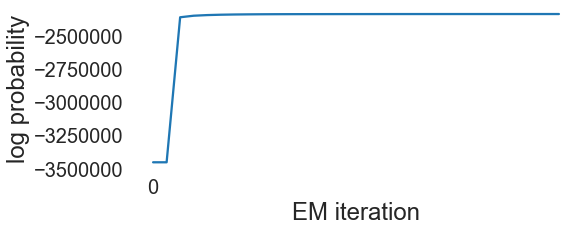

In [24]:
######### LogL
plt.figure(figsize=(8, 3))
plt.plot(hmm_lls)
plt.xlabel("EM iteration", fontsize=24)
plt.ylabel("log probability", fontsize=24)
plt.yticks(fontsize=20)
plt.xticks(np.arange(0, N_iters, step=40), fontsize=20)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.show()

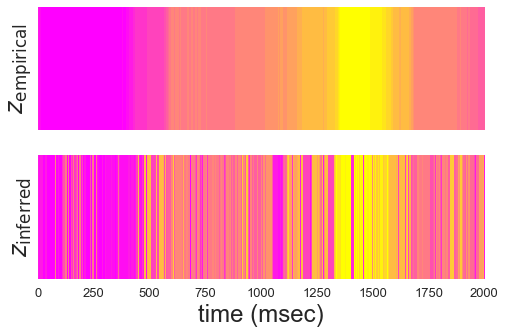

In [27]:
######## Zs
plt.figure(figsize=(8, 5))
plt.subplot(211)
plt.imshow(z_true[None,:], cmap='spring', aspect="auto")
plt.ylabel("$z_{\\mathrm{empirical}}$", fontsize=24)
plt.xlim(0, 2000)
plt.yticks([])
plt.xticks([])
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.subplot(212)
plt.imshow(hmm_z[None,:], cmap='spring', aspect="auto")
plt.ylabel("$z_{\\mathrm{inferred}}$", fontsize=24)
plt.yticks([])
plt.xlim(0, 2000)
plt.xlabel("time (msec)", fontsize=24)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

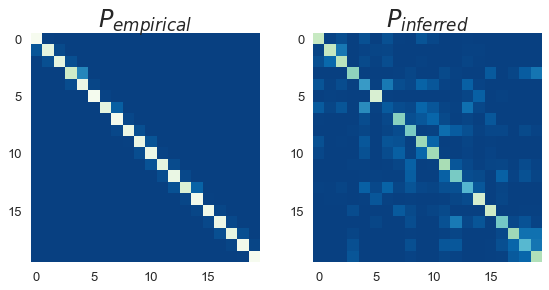

In [28]:
######## Ps
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(A, aspect="equal", cmap="GnBu_r", vmin=0, vmax=1)
plt.xlim(-.5,K-.5)
plt.ylim(K-.5,-.5)
plt.xticks(np.arange(0, K, step=5))
plt.yticks(np.arange(0, K, step=5))
plt.title("$P_{empirical}$", fontsize=24)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.subplot(122)
plt.imshow(hmm.transitions.transition_matrix, aspect="equal", cmap="GnBu_r", vmin=0, vmax=1)
plt.xlim(-.5,K-.5)
plt.ylim(K-.5,-.5)
plt.xticks(np.arange(0, K, step=5))
plt.yticks(np.arange(0, K, step=5))
plt.title("$P_{inferred}$", fontsize=24)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

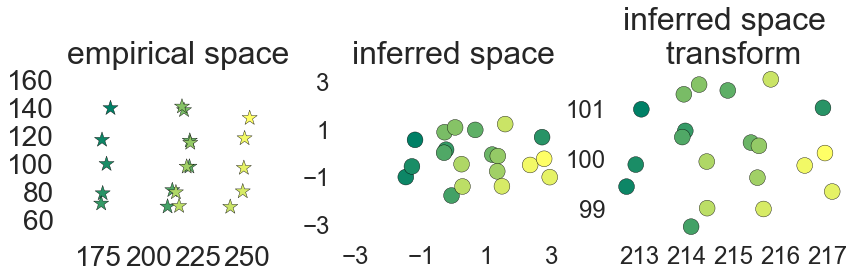

In [29]:
##### ell
plt.figure(figsize=(14, 3))
plt.subplot(131)
plt.scatter(true_maze[:,0], true_maze[:,1], 
            c=range(K), cmap="summer", marker="*", s=250, edgecolors='k', alpha=1)
plt.title("empirical space", fontsize=32)
plt.xlim(np.min(pos_x)-10, np.max(pos_x)+10)
plt.ylim(np.min(pos_y)-10, np.max(pos_y)+10)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.subplot(132)
plt.scatter(ell_hmm[:,0], ell_hmm[:,1], 
            c=range(K), cmap="summer", marker="o", s=250, edgecolors='k', alpha=1)
plt.title("inferred space", fontsize=32)
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)
plt.xticks(np.arange(-3, 3.01, step=2), fontsize=24)
plt.yticks(np.arange(-3, 3.01, step=2), fontsize=24)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.subplot(133)
plt.scatter(ell_transform[:,0], ell_transform[:,1], 
            c=range(K), cmap="summer", marker="o", s=250, edgecolors='k', alpha=1)
plt.title("inferred space \n transform", fontsize=32)
#plt.xlim(np.min(pos_x)-10, np.max(pos_x)+10)
#plt.ylim(np.min(pos_y)-10, np.max(pos_y)+10)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.subplots_adjust(top=0.9)
plt.show()
